# Parallax effect

This tutorial demonstrates the parallax effect observed at large incidence angles with low-Z sensor materials.

It uses one of the reference images available in the pyFAI test suite: a diffraction frame of corundum taken at ID13 with an Eiger detector and a beam of energy 13.45 keV.

## Initialization

In [1]:
%matplotlib inline
import time
import copy
from matplotlib.pyplot import subplots
from scipy.sparse import csc_array
import fabio
import pyFAI
from pyFAI.gui import jupyter
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import get_calibrant
import pyFAI.ext.parallax_raytracing

kwargs = {
    "npt": 2000,  # this is a lot of oversampling ... do not use with actual images.
    "method": (
        "no",
        "histogram",
        "cython",
    ),  # without pixel splitting, results are correct despite ugly images.
    "unit": "2th_deg",
    "radial_range": (10, 40),
    "dummy": 4e9,
    "delta_dummy": 1e9,
}

print(f"Using pyFAI version {pyFAI.version}")
start_time = time.perf_counter()

Using pyFAI version 2026.1.0-dev0


## Display the image and the powder diffraction pattern

In [2]:
ai = pyFAI.load(UtilsTest.getimage("Eiger4M.poni"))
ai0 = copy.deepcopy(ai)  # this integrator does not know about parallax effect !
ai0

Detector Eiger 4M	 PixelSize= 75µm, 75µm	 BottomRight (3)
Wavelength= 0.921816 Å
SampleDetDist= 1.625582e-01 m	PONI= 9.632499e-02, 8.636842e-02 m	rot1=0.004596  rot2=0.000846  rot3=-0.000000 rad
DirectBeamDist= 162.560 mm	Center: x=1141.617, y=1286.167 pix	Tilt= 0.268° tiltPlanRotation= 169.572° λ= 0.922Å

In [3]:
alumine = get_calibrant("alpha_Al2O3")
alumine.wavelength = ai.wavelength

In [4]:
# Define sensor info to enable parallax:
ai.enable_parallax(True, sensor_material="Si", sensor_thickness=450e-6)
ai.detector.sensor = ai.parallax.sensor
ai

Detector Eiger 4M	 PixelSize= 75µm, 75µm	 BottomRight (3)	 Thin sensor with µ=4108.472 1/m, thickness=0.00045m and efficiency=0.843
Wavelength= 0.921816 Å	Parallax: µ= 41.085 cm⁻¹
SampleDetDist= 1.625582e-01 m	PONI= 9.632499e-02, 8.636842e-02 m	rot1=0.004596  rot2=0.000846  rot3=-0.000000 rad
DirectBeamDist= 162.560 mm	Center: x=1141.617, y=1286.167 pix	Tilt= 0.268° tiltPlanRotation= 169.572° λ= 0.922Å

In [5]:
ai.energy

13.450000402192138

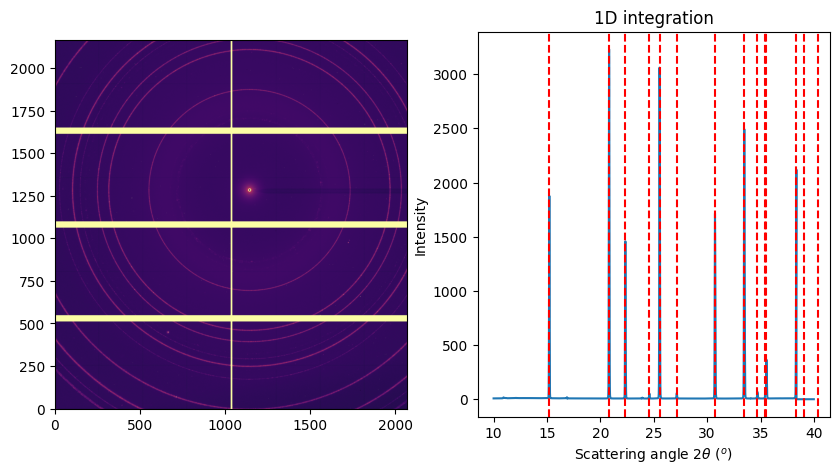

In [6]:
fig, ax = subplots(1, 2, figsize=(10, 5))
img_ref = fabio.open(UtilsTest.getimage("Eiger4M.edf")).data
jupyter.display(img_ref, ax=ax[0])
jupyter.plot1d(ai0.integrate1d(img_ref, **kwargs), ax=ax[1], calibrant=alumine);

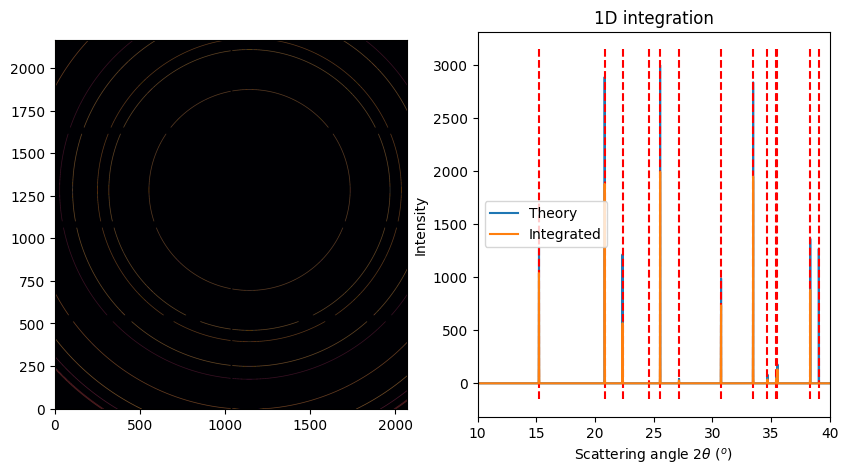

In [7]:
# prepare a synthetic dataset almost equivalent

ref_xrpd = alumine.fake_xrpdp(
    3000,
    (10, 40),
    resolution=1e-2,  # very fine resolution, finer than the pixel size
    unit="2th_deg",
    Imax=3e3,
)
img_ref = ai0.calcfrom1d(ref_xrpd.radial, ref_xrpd.intensity, mask=ai.detector.mask)
reintegrated = ai0.integrate1d(img_ref, **kwargs)

fig, ax = subplots(1, 2, figsize=(10, 5))
jupyter.display(img_ref, ax=ax[0])
jupyter.plot1d(ref_xrpd, ax=ax[1], calibrant=alumine, label="Theory")
ax[1].plot(*reintegrated, label="Integrated")
ax[1].set_xlim(10, 40)
ax[1].legend();

## Calculate the bluring operator as a sparse matrix

In [8]:
rt = pyFAI.ext.parallax_raytracing.Raytracing(ai, buffer_size=32)

In [9]:
%%time 
sparse = csc_array(
    rt.calc_csr(32),  # throw 32x32=1024 rays per pixel ... can take a while
    shape=(img_ref.size, img_ref.size),
)

CPU times: user 8min 51s, sys: 535 ms, total: 8min 51s
Wall time: 11.3 s


Apply parallax bluring on the image as sparse matrix multiplication:

In [10]:
img_par = sparse.dot(img_ref.ravel()).reshape(img_ref.shape)

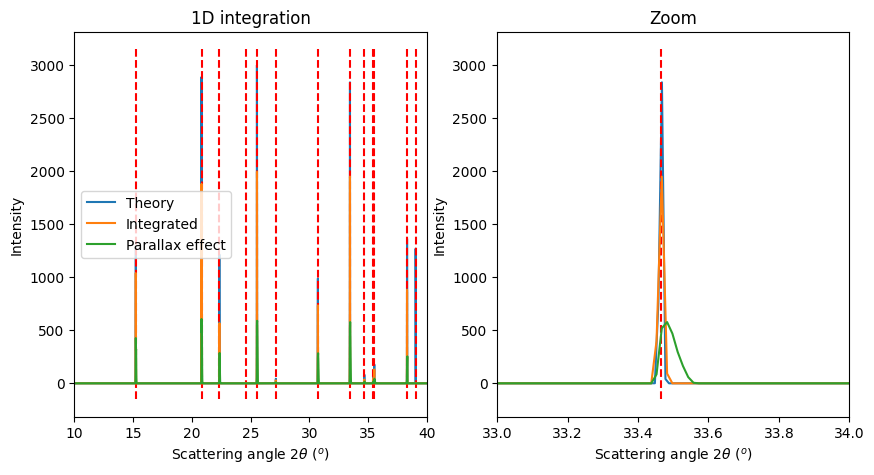

In [11]:
res0 = ai0.integrate1d(img_ref, **kwargs)
res1 = ai0.integrate1d(img_par, **kwargs)

fig, ax = subplots(1, 2, figsize=(10, 5))
jupyter.plot1d(ref_xrpd, label="Theory", ax=ax[0], calibrant=alumine)
jupyter.plot1d(ref_xrpd, ax=ax[1], calibrant=alumine)
ax[0].plot(*res0, label="Integrated")
ax[1].plot(*res0, label="Integrated")
ax[0].plot(*res1, label="Parallax effect")
ax[1].plot(*res1, label="Parallax effect")
ax[0].set_xlim(10, 40)
ax[1].set_xlim(33, 34)
ax[1].set_title("Zoom")
ax[0].legend();

## Correction of the parallax effect within the integrator

In [12]:
# Use the sensor material aware azimuthal integrator:
res2 = ai.integrate1d(img_par, **kwargs)

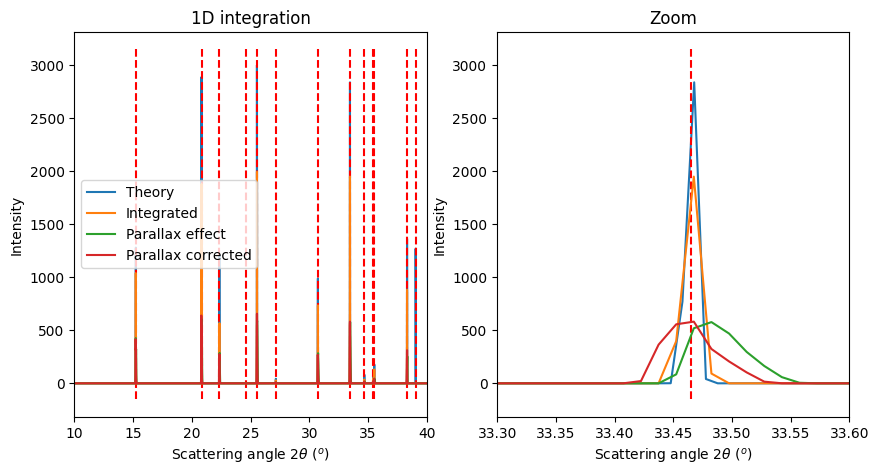

In [13]:
fig, ax = subplots(1, 2, figsize=(10, 5))
jupyter.plot1d(ref_xrpd, label="Theory", ax=ax[0], calibrant=alumine)
jupyter.plot1d(ref_xrpd, ax=ax[1], calibrant=alumine)
ax[0].plot(*res0, label="Integrated")
ax[1].plot(*res0, label="Integrated")
ax[0].plot(*res1, label="Parallax effect")
ax[1].plot(*res1, label="Parallax effect")

ax[0].plot(*res2, label="Parallax corrected")
ax[1].plot(*res2, label="Parallax corrected")

ax[0].set_xlim(10, 40)
ax[1].set_xlim(33.3, 33.6)

ax[1].set_title("Zoom")
ax[0].legend();

As shown, when the parallax correction is activated in the geometry/azimuthal integrator, the peak position (maximum) is shifted to the correct value. However, this correction does not deconvolve the peak shape (it does not remove the broadening introduced by parallax).

## Conclusion
PyFAI provides tools to simulate the parallax effect using raytracing.
The sparse matrix obtained can be used to blur a diffraction image and later to deconvolve it using iterative methods like MLEM.
It is also able to take volumetric absorption effects into account to correct the peak position.

In [14]:
print(f"Runtime: {time.perf_counter() - start_time:.3f}s")

Runtime: 16.994s
